In [27]:
import pandas as pd
import shap
import joblib
from catboost import Pool
from sklearn import set_config


#Functions
#General Functions
#Parsing Cabin
def parse_cabin(df):
    cabin = df["Cabin"].str.split("/", expand=True)
    df["CabinDeck"] = cabin[0]
    df["CabinNum"] = pd.to_numeric(cabin[1], errors="coerce")
    df["CabinSide"] = cabin[2]

    return df

#Extracting group
def add_group_sizes(df):
    df["GroupId"] = df["PassengerId"].str.split("_").str[0]
    df["GroupSize"] = df.groupby("GroupId")["GroupId"].transform("size")

    return df

#Main code
set_config(transform_output="pandas")

artifact = joblib.load("spaceship_model.joblib")

model = artifact["model"]
num_pipeline = artifact["num_pipeline"]
cat_pipeline = artifact["cat_pipeline"]
cols = artifact["feature_columns"]
cat_indices = artifact["cat_indices"]

train_df = pd.read_csv("train.csv")

X = train_df.drop(columns=["Transported"])

X = parse_cabin(X)
X = add_group_sizes(X)

X = X.drop(columns=["PassengerId", "Cabin", "Name", "GroupId"])

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["category", "object"]).columns

X[num_cols] = num_pipeline.transform(X[num_cols])
X[cat_cols] = cat_pipeline.transform(X[cat_cols])

# Ensure correct column order
X = X[cols]

In [28]:
#SHAP Analysis
X_sample = X.sample(500, random_state=42)

pool = Pool(X_sample, cat_features=cat_indices)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(pool)

print(explainer)

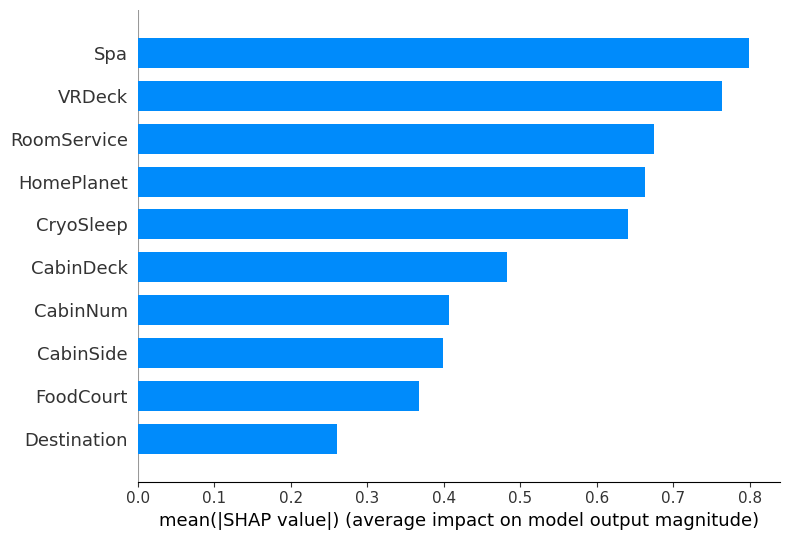

In [29]:
shap_bar = shap.summary_plot(shap_values, X_sample, max_display=10, plot_type="bar")

In [30]:
import numpy as np

shap_mean_abs = pd.DataFrame({
    "feature": X_sample.columns,
    "mean_abs_shap": np.abs(shap_values).mean(axis=0)
}).sort_values(by="mean_abs_shap", ascending=False)

top_features = shap_mean_abs.head(10)
print(top_features)

        feature  mean_abs_shap
8           Spa       0.799386
9        VRDeck       0.763125
5   RoomService       0.674907
0    HomePlanet       0.662436
1     CryoSleep       0.640318
10    CabinDeck       0.482161
11     CabinNum       0.406966
12    CabinSide       0.398664
6     FoodCourt       0.367598
2   Destination       0.260993


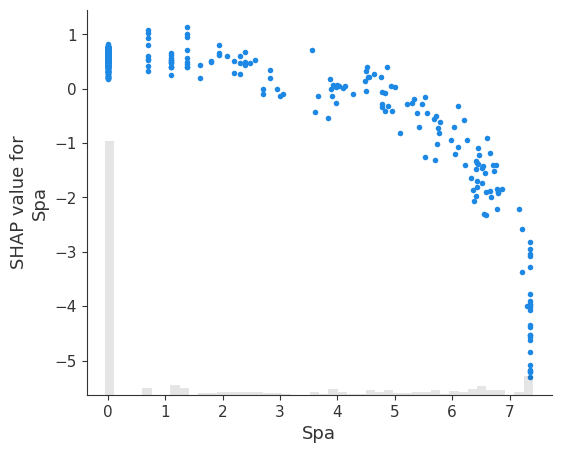

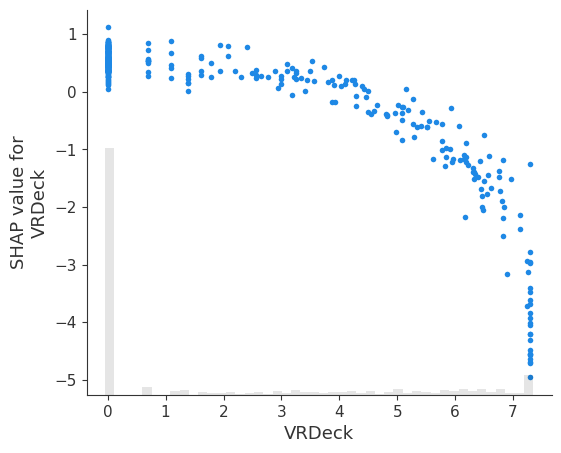

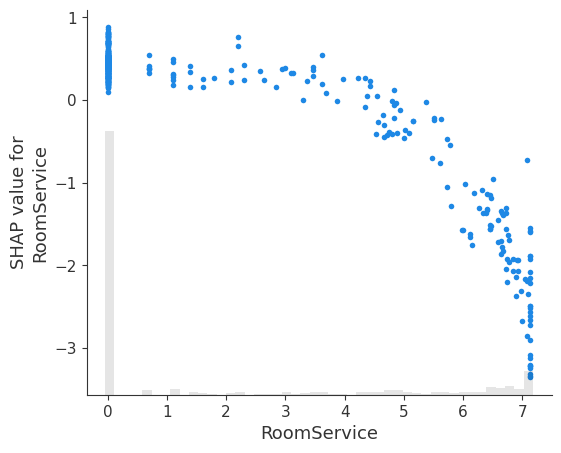

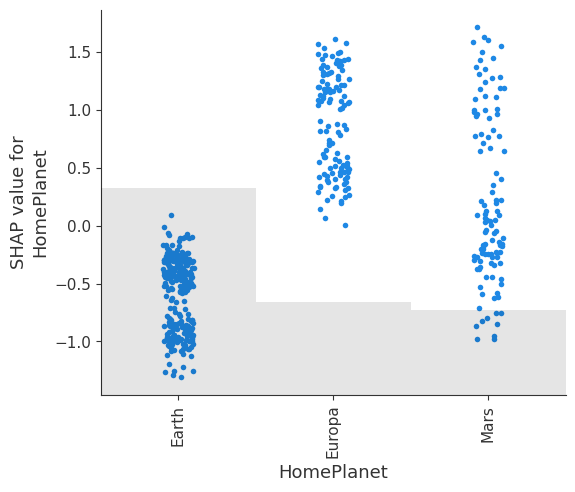

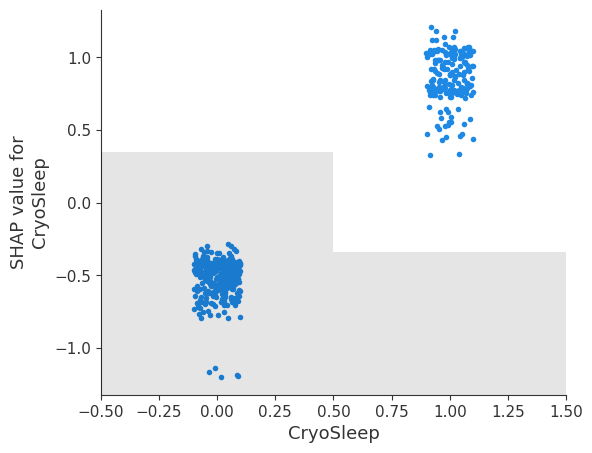

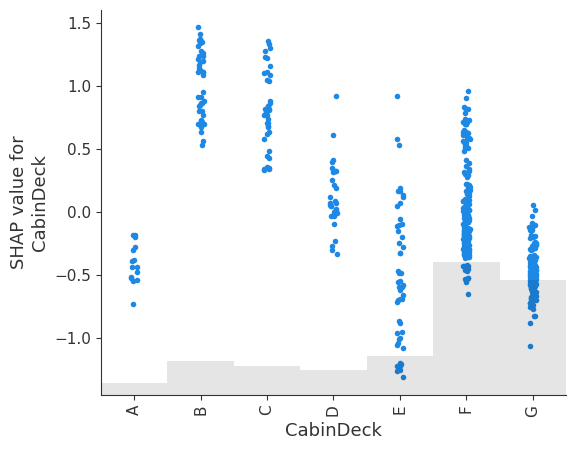

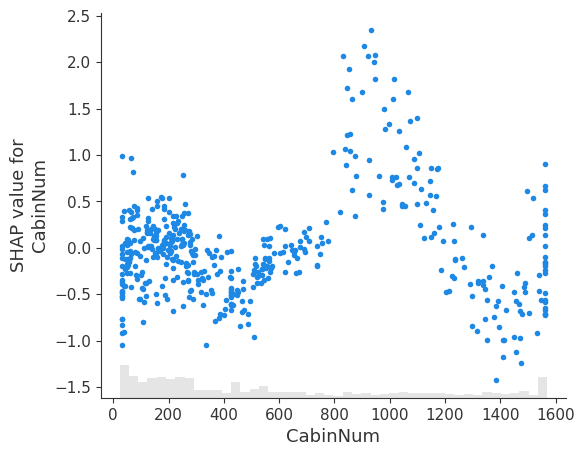

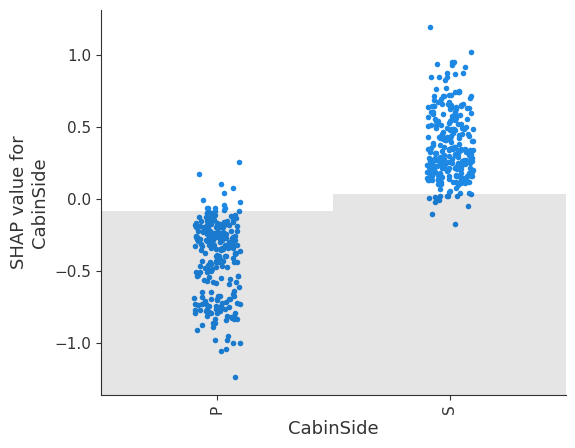

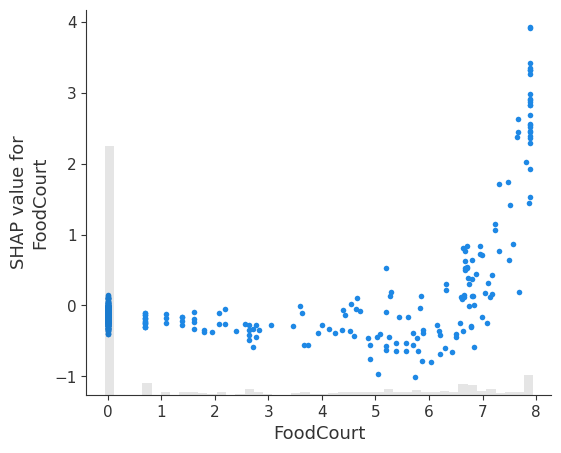

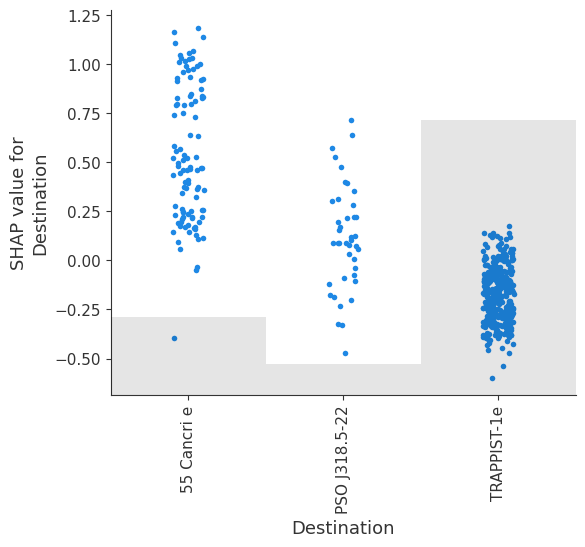

In [33]:
shap_exp = explainer(X_sample)

for feature in top_features["feature"]:
    idx = X_sample.columns.get_loc(feature)

    shap.plots.scatter(shap_exp[:, idx])

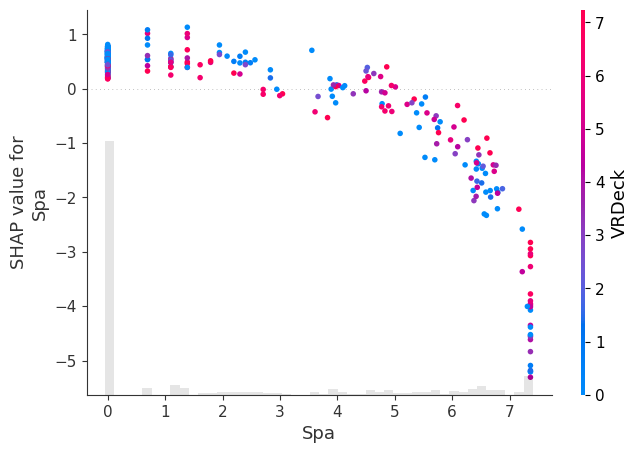

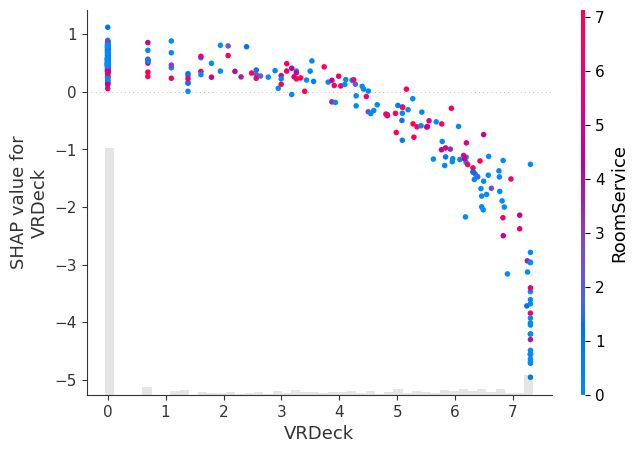

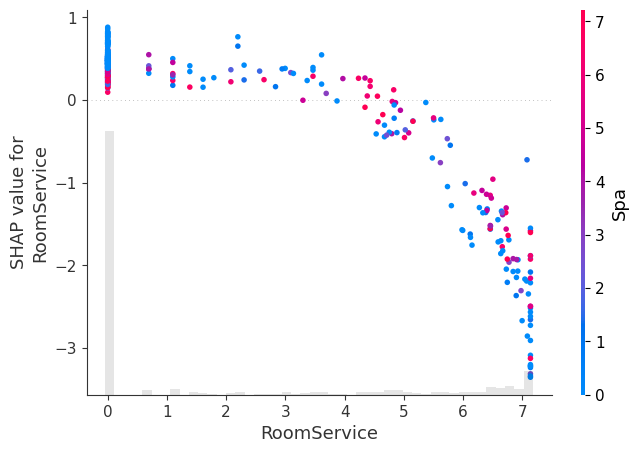

In [34]:
shap.plots.scatter(shap_exp[:, "Spa"], color=shap_exp[:, "VRDeck"])
shap.plots.scatter(shap_exp[:, "VRDeck"], color=shap_exp[:, "RoomService"])
shap.plots.scatter(shap_exp[:, "RoomService"], color=shap_exp[:, "Spa"])

In [39]:
import matplotlib.pyplot as plt

#Plot 1: Global Importance Plot
shap.summary_plot(shap_values, X_sample, max_display=10, plot_type="bar", show=False)
plt.savefig("shap_summary_bar.png", dpi=300)
plt.close()

#Plot 2: Dependence Plot for 1 feature
shap.plots.scatter(
    shap_exp[:, "Spa"],
    color=shap_exp[:, "VRDeck"].values,
    show=False
)
plt.savefig("shap_spa_vr.png", dpi=300)
plt.close()

#Plot 3: Force Plot
rand_num = np.random.default_rng().integers(1, 500)
shap.save_html(f"shap_force_plot_{rand_num}.html", shap.force_plot(shap_exp[rand_num]))